# Implemention of leg taste sensing to mimic egg-laying decision making, Nathan Guillaumat, 28/05/2024

##### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange
import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed
from flygym.mujoco import Parameters
from IPython.display import Video
from flygym.mujoco.examples.common import PreprogrammedSteps
from ImageTerrain_class import ImageTerrain
from NMF_class import SucroseSensorNMF
from skimage import io
from numpy.random import choice, randint
import random
from skimage.draw import (
    disk,
)

##### Path and directory for videos

In [3]:
Path("outputs/").mkdir(exist_ok=True)  # Create directory for generated videos

## Image creation

Function for the memory of the fly, in order to map what pixels belong to what disk : 

In [4]:
def get_pixels_in_disk(center, radius, shape):
    x_center, y_center = center
    height, width = shape
    disk_pixels = []

    for x in range(height):
        for y in range(width):
            if (x - x_center)**2 + (y - y_center)**2 <= radius**2:
                disk_pixels.append((x, y))

    return np.array(disk_pixels)

Map image creation

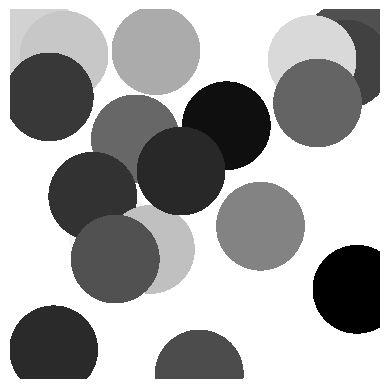

In [5]:
#------------------ random map -----------------
# White circle in the from of the fly
img_pixels = 5000
dpi=(10/3.696)*img_pixels/10 #To create a 5000x5000 pixels image
img = np.zeros((img_pixels, img_pixels, 3), dtype=np.double)
img_rand = np.ones((img_pixels, img_pixels), dtype=np.uint8)*255
nb_shapes = 20 #50 good with memory 
centers_position = []
radius = 600
img_centers = np.zeros((img_pixels, img_pixels, 2))

for i in range(nb_shapes):
    x_center = randint(10, img_pixels-10)
    y_center = randint(10, img_pixels-10)
    centers_position.append([x_center,y_center,1.5])
    rr, cc = disk((x_center, y_center), radius, shape=img.shape)
    value = random.uniform(0, 255)
    img_rand[rr, cc] = value

    # Memory
    # disk_pixels = get_pixels_in_disk((x_center, x_center), radius, (img_pixels,img_pixels))
    # for px in disk_pixels:
    #     img_centers[px[0], px[1]] = (x_center, y_center)

# Initial position of the fly
# rr, cc = disk((2500, 2500), 10, shape=img.shape)
# img_rand[rr, cc] = 0

img_rand = np.transpose(img_rand)
fig_rand = plt.imshow(img_rand, cmap="gray", interpolation='nearest')
plt.axis('off')
fig_rand.axes.get_xaxis().set_visible(False)
fig_rand.axes.get_yaxis().set_visible(False)
plt.savefig("./outputs/random_map.png", bbox_inches='tight', pad_inches = 0, dpi=dpi)

Check cell to see if the image is the right shape (should be (img_pixels,img_pixels,4), RGBA format)

In [6]:
test_path: str = r"./outputs/random_map.png"
tab2 = io.imread(test_path, as_gray=False).astype('uint8')
print(tab2.shape)

(5000, 5000, 4)


## Simulation parameters

Simulation, arena and NeuroMechFly initialization 

In [7]:
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    render_window_size=(800, 608), 
    enable_olfaction=True,
    enable_adhesion=True,
    render_camera="Animat/camera_top",
)

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

image_arena = ImageTerrain(image_size=(img_pixels,img_pixels), image_path = "./outputs/random_map.png", img_centers=img_centers)

nmf = SucroseSensorNMF(
    sim_params=sim_params,
    arena=image_arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    egg_laying_speed = 100, #K parameter: 1000 good for 0.5 sim, 300 good for 1s
    egg_laying_time = 0.2 #Stop duration to lay an egg
)

actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs


Visual inspection of the starting position

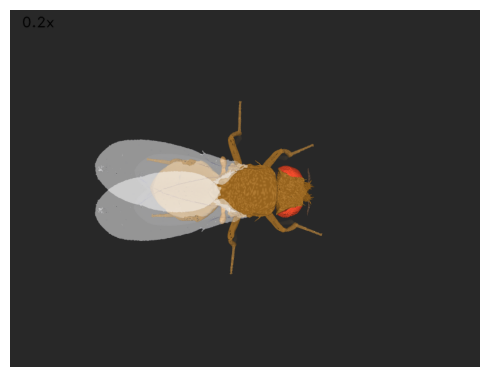

In [8]:
for i in range(500):
    nmf.step(np.zeros(2))
    nmf.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(nmf._frames[-1])
ax.axis("off")
fig.savefig("./outputs/test_image.png")

## Random walking

Randomization functions :

In [9]:
movements = np.array([[1,1], [1.2,0.2], [0.2,1.2]])
mvt_names = ["Straight", "Turning right", "Turning left"]
legs_pond = ["left_legs", "right_legs"]
times = np.arange(0, 1, 0.1, dtype=float)


def random_movement():
    mvt_table = pd.DataFrame(movements, index=mvt_names, columns=legs_pond)

    number_of_items_to_pick = 1
    probability_distribution = np.array([0.7, 0.15, 0.15])
    mvt_draw = choice(mvt_names, number_of_items_to_pick,
                p=probability_distribution)

    action = np.array([mvt_table.loc[mvt_draw[0],"left_legs"], mvt_table.loc[mvt_draw[0],"right_legs"]])
    return action

def random_time():
    time = choice(times, 1)
    return time


## Simulation functions

In [11]:
run_time = 15
choices = np.array([])
timing = np.array([])
action = np.array([1,1])
r_time = 2*nmf.sim_params.timestep
counter = 0
counter_egg = 0
egg_laying = 0
target_num_steps = int(run_time / nmf.sim_params.timestep)

#Initialisation of variables to get data
sucrose_levels = []
fly_trajectory = []
touched_zone = []
touched_zone_map = []
egg_prob = []
egg_decision=[]
egg_position = []
zones = []

# Abdomen control (not used)
# abdomen_control = np.sin(
#     2 * 2 * np.pi * np.linspace(0, run_time, target_num_steps) / run_time
# )
# scale abdomen control between -pi/10 and 3pi/10
# abdomen_control = abdomen_control * np.pi / 5 + np.pi / 10

preprogrammed_steps = PreprogrammedSteps()
leg_action = []
for leg in preprogrammed_steps.legs:
    # fly is standing
    leg_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))


# Simulation loop
obs, info = nmf.reset(seed=0)
for i in trange(target_num_steps):
    curr_time = i * nmf.sim_params.timestep

    if (obs['egg_decision'] == 1):
        egg_laying = 1
        print("I lay an egg")

    if (egg_laying == 1):
        counter_egg+=1
        counter_time_egg = counter_egg * nmf.sim_params.timestep
        action = np.array([0,0])
        if(counter_time_egg==nmf.egg_laying_time):
            egg_laying = 0
            counter_egg = 0
            egg_position.append([obs['fly'][0][0], obs['fly'][0][1]])
            counter = 0
            action = random_movement()
            r_time = random_time()
            choices = np.append(choices, action)
            timing = np.append(timing, r_time)
        obs, reward, terminated, truncated, info = nmf.step(action)
        
    else:
        counter += 1
        counter_time = counter * nmf.sim_params.timestep
        if (counter_time==r_time):
            counter = 0
            action = random_movement()
            r_time = random_time()
            choices = np.append(choices, action)
            timing = np.append(timing, r_time)
        obs, reward, terminated, truncated, info = nmf.step(action)

    # Abdomen bending action (not used)
    # if False:
    #     joint_pos = np.hstack([leg_action, abdomen_control[i] * np.ones(5)])
    #     action = {"joints": joint_pos}
    #     obs, reward, terminated, truncated, info = act_abd_nmf.step(action)

    # Data for analysis
    sucrose_levels.append(obs['sucrose'])
    fly_trajectory.append([obs['fly'][0][0], obs['fly'][0][1]])
    egg_prob.append(obs['egg_probability'])
    egg_decision.append(obs['egg_decision'])
    zones.append(obs['visited_zones'])

    #Render with pink sucrose scale 
    f = nmf.render()
    if not f is None:
        #obs['sucrose'] = np.ones(6)
        f = nmf._frames[-1]
        f[-50:, :int(800*np.mean(obs['sucrose'])/256), :] = [255, 0, 255]
        nmf._frames[-1] = f


  3%|▎         | 4857/150000 [00:49<16:08, 149.91it/s] 

I lay an egg


  7%|▋         | 10582/150000 [01:32<15:36, 148.91it/s]

I lay an egg


 11%|█         | 16330/150000 [02:15<13:30, 164.86it/s]

I lay an egg


 15%|█▍        | 22100/150000 [02:57<16:39, 127.97it/s]

I lay an egg


 19%|█▊        | 27853/150000 [03:40<14:26, 140.90it/s]

I lay an egg


 22%|██▏       | 33584/150000 [04:22<12:42, 152.64it/s]

I lay an egg


 26%|██▌       | 39319/150000 [05:13<14:13, 129.64it/s]

I lay an egg


 30%|███       | 45103/150000 [06:03<14:43, 118.71it/s]

I lay an egg


 34%|███▍      | 51449/150000 [06:52<10:54, 150.49it/s]

I lay an egg


 45%|████▍     | 67443/150000 [08:55<09:09, 150.37it/s]

I lay an egg


 51%|█████     | 76162/150000 [10:00<09:11, 133.88it/s]

I lay an egg


 57%|█████▋    | 84858/150000 [11:05<07:08, 151.92it/s]

I lay an egg


 62%|██████▏   | 93577/150000 [12:09<06:06, 153.78it/s]

I lay an egg


 68%|██████▊   | 102302/150000 [13:22<07:16, 109.33it/s]

I lay an egg


 74%|███████▍  | 111020/150000 [14:43<06:40, 97.26it/s] 

I lay an egg


 80%|███████▉  | 119721/150000 [16:07<03:41, 136.87it/s]

I lay an egg


 86%|████████▌ | 128453/150000 [17:30<02:54, 123.22it/s]

I lay an egg


 91%|█████████▏| 137181/150000 [18:50<01:49, 117.58it/s]

I lay an egg


 97%|█████████▋| 145911/150000 [20:11<00:28, 144.42it/s]

I lay an egg


100%|██████████| 150000/150000 [20:45<00:00, 120.45it/s]


## Video

In [12]:
nmf.save_video("./outputs/Random_Walking_Sensor.mp4")
Video("./outputs/Random_Walking_Sensor.mp4")

## Plots

Trajectory (blue) and laid eggs (red stars)

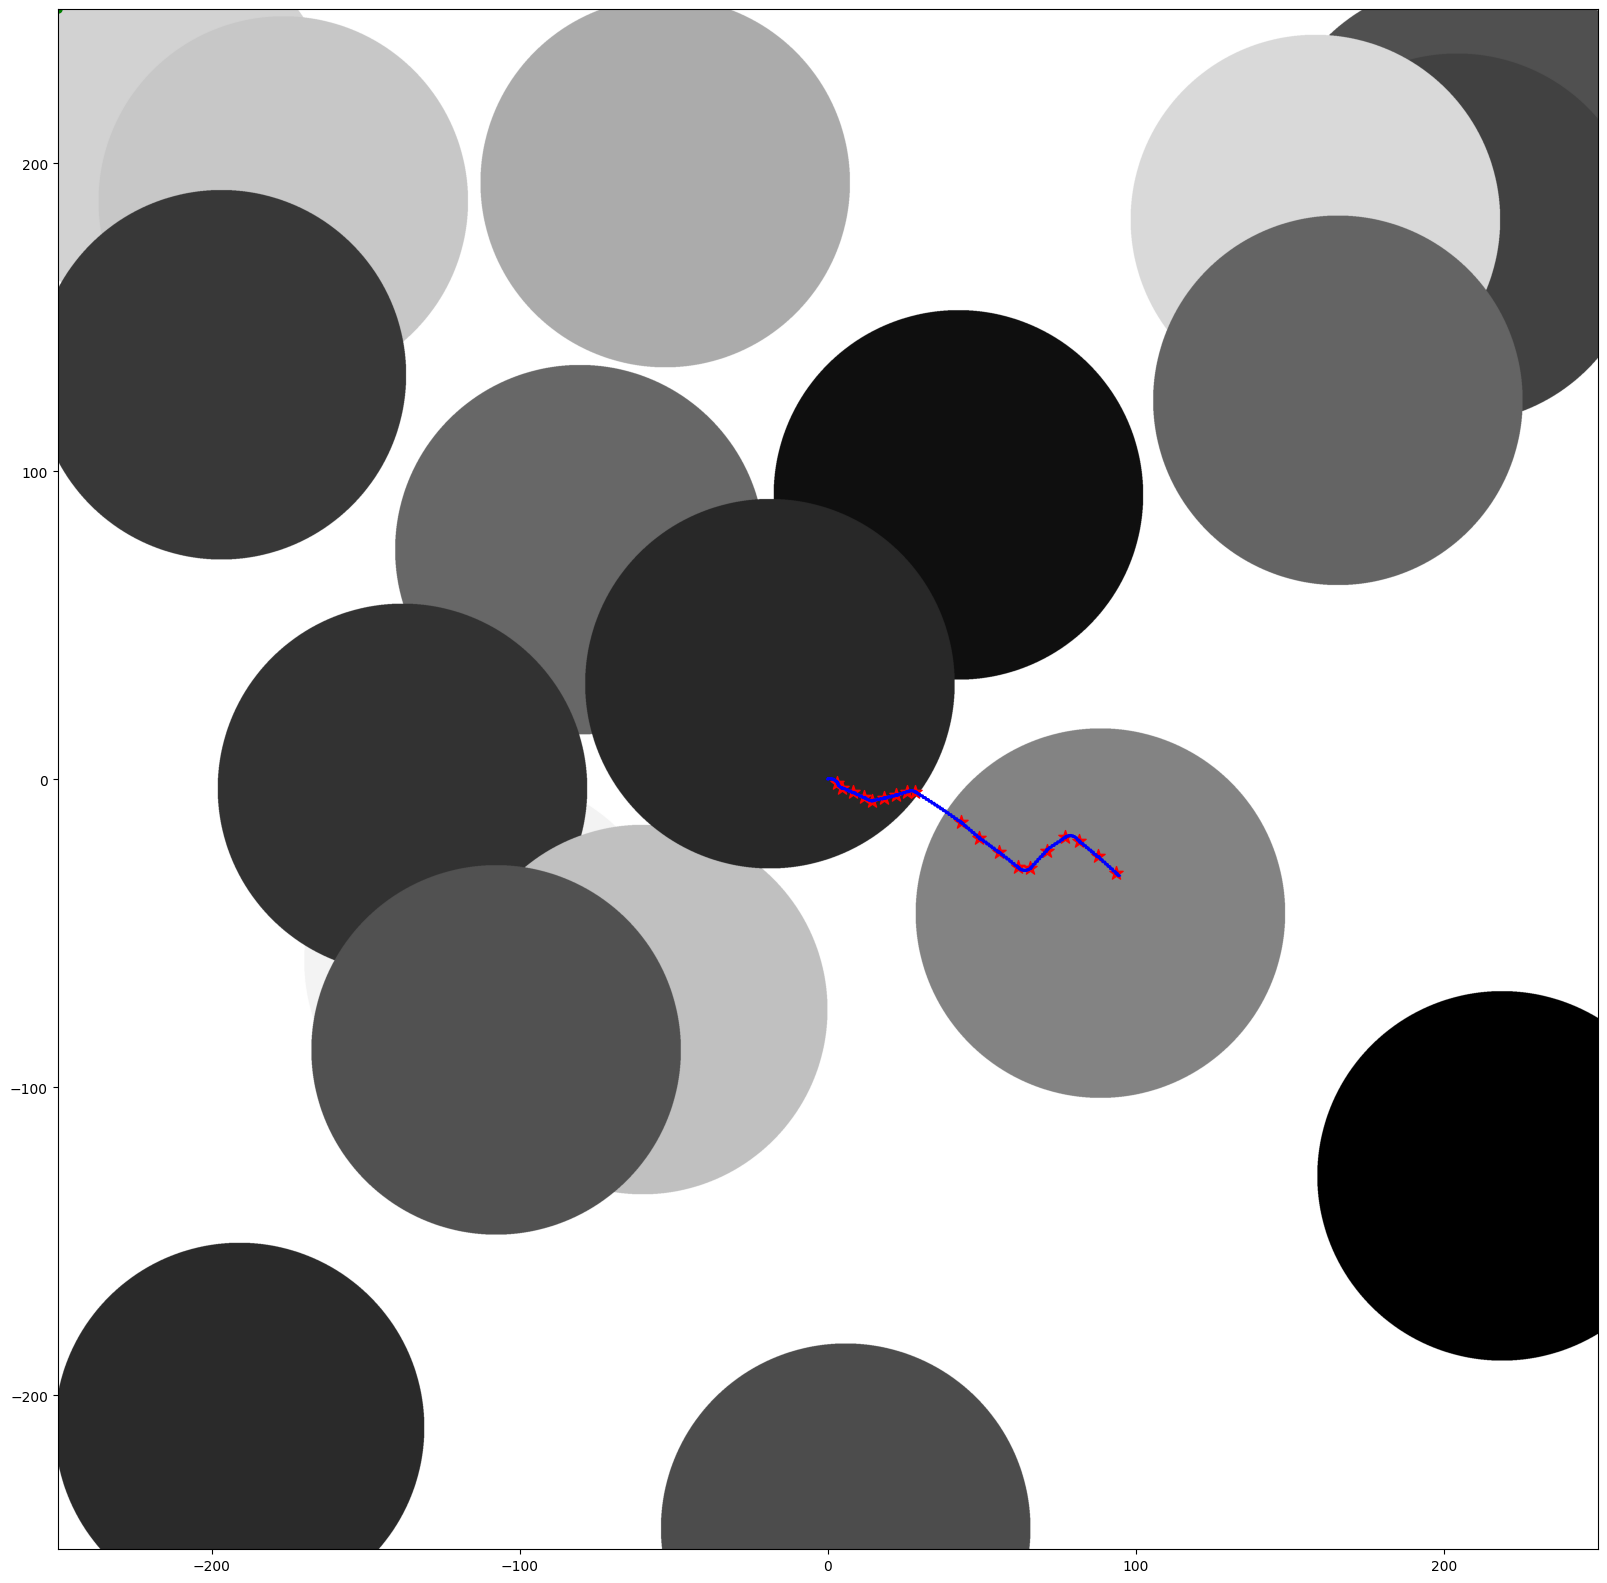

In [13]:
img = plt.imread("./outputs/random_map.png")
fig, ax = plt.subplots(figsize = (20,20))
x = [pos[0] for pos in fly_trajectory]
y = [pos[1] for pos in fly_trajectory]

touched_x = [pos[0] for pos in egg_position]
touched_y = [pos[1] for pos in egg_position]

unique_zones = np.unique(np.concatenate(zones), axis=0)
zones_x = [pos[0]/10-250 for pos in unique_zones]
zones_y = [250-pos[1]/10 for pos in unique_zones]

ax.scatter(touched_x, touched_y, marker='*', color='red', s=100)
ax.scatter(zones_x, zones_y, marker='.', color='green', s=100)



ax.imshow(img, extent=[-250, 250, -250, 250])
# ax.plot(x, y, '--', linewidth=2, color='firebrick')
ax.plot(x, y, linewidth=2, color='blue')


Detected sucrose at each time of the simulation

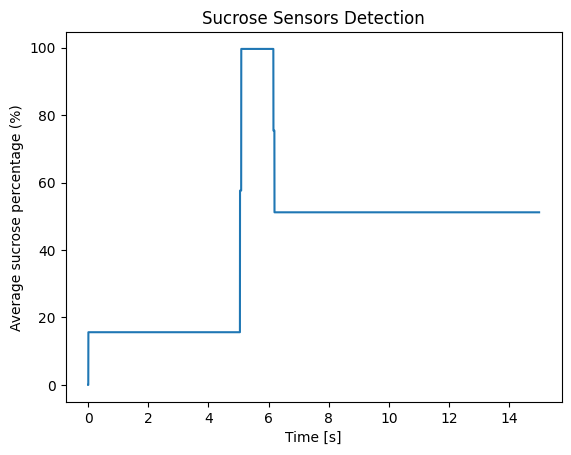

In [14]:
suc = np.array(sucrose_levels)
mean_suc = np.mean(suc, axis=1)
x = np.linspace(0, run_time, len(suc))
plt.plot(x, mean_suc/256*100)
plt.xlabel("Time [s]")
plt.ylabel("Average sucrose percentage (%)")
plt.title("Sucrose Sensors Detection")
plt.show()


Internal variable of the fly to lay an egg. Lay and egg when one is reached

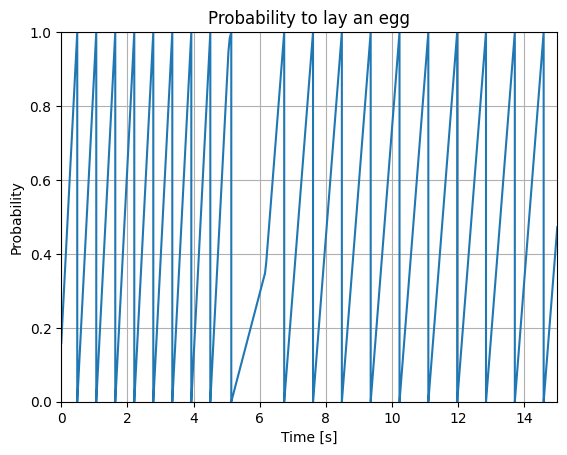

In [15]:
prob = np.array(egg_prob)
x = np.linspace(0, run_time, len(prob))
plt.plot(x, prob)
plt.xlabel("Time [s]")
plt.ylabel("Probability")
plt.title("Probability to lay an egg")
plt.xlim(0, run_time)  # Adjust the x-axis limits
plt.ylim(0, 1)   # Adjust the y-axis limits
plt.grid(True)  # Add grid lines for better visualization
plt.show()